In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils.fem_utils import WaveguideTemplate

import gdsfactory as gf

from utils.meep_utils.runner import MeepRunner
from utils.meep_utils.digital_twins.dc import DirectionalCouplerTwin, StraightCouplerTwin
from utils.general_utils import interpolate_design_parameter, plot_spectra

#### Cross section definition (Femwell)

In [2]:
# --- Design Parameters ---
n_core=3.47        # Silicon
n_box=1.444        # Bottom Oxide
n_clad=1.444       # Top Oxide (Symmetric is standard for Couplers)
thickness=0.22     # 220 nm
slab_thickness=0.0 # Strip Waveguide
domain_width=6.0
resolution=0.03    # High resolution for accurate gap physics

wavelength = 1.55
width = 0.5                      # Standard waveguide width
gaps = np.linspace(0.1, 0.5, 10) # Sweep Gap from 100nm to 500nm
target_gap = 0.4                 # Smallest gap that is manufacturable (e.g., > 150 nm) to keep the device short.

process_pdk = WaveguideTemplate(
    n_core=n_core,       
    n_box=n_box,      
    n_clad=n_clad,      
    thickness=thickness,     
    slab_thickness=slab_thickness, 
    domain_width=domain_width,
    resolution=resolution  
)

In [3]:
lc_list = []
l3db_list = []

print(f"Starting Coupler Design Sweep...")

# --- Physics Sweep ---
for gap in gaps:
    try:
        n_even, n_odd = process_pdk.solve_coupler(
            width=width, gap=gap, wavelength=wavelength)
        
        delta_n = n_even - n_odd
        L_pi = wavelength / (2 * delta_n)
        
        lc_list.append(L_pi)
        l3db_list.append(L_pi / 2)
        
        print(f"Gap={gap:.2f}um | dn={delta_n:.4f} | L_3dB={L_pi/2:.2f} um")
        
    except ValueError as e:
        print(f"Gap={gap:.2f}um: {e}")
        lc_list.append(np.nan)
        l3db_list.append(np.nan)

Starting Coupler Design Sweep...
Gap=0.10um | dn=0.0560 | L_3dB=6.92 um
Gap=0.14um | dn=0.0362 | L_3dB=10.70 um
Gap=0.19um | dn=0.0242 | L_3dB=16.00 um
Gap=0.23um | dn=0.0163 | L_3dB=23.73 um
Gap=0.28um | dn=0.0110 | L_3dB=35.15 um
Gap=0.32um | dn=0.0076 | L_3dB=51.22 um
Gap=0.37um | dn=0.0051 | L_3dB=75.57 um
Gap=0.41um | dn=0.0035 | L_3dB=110.22 um
Gap=0.46um | dn=0.0024 | L_3dB=161.73 um
Gap=0.50um | dn=0.0016 | L_3dB=238.55 um


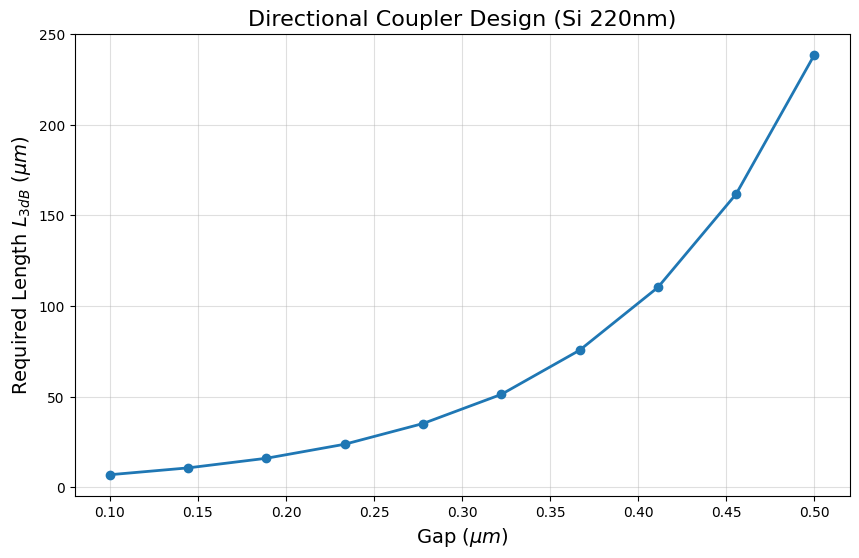

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(gaps, l3db_list, 'o-', linewidth=2)
ax.set_xlabel(r'Gap ($\mu m$)', fontsize=14)
ax.set_ylabel(r'Required Length $L_{3dB}$ ($\mu m$)', fontsize=14)
ax.set_title(f"Directional Coupler Design (Si 220nm)", fontsize=16)
ax.grid(True, alpha=0.4)
plt.show()

We need to interpolate to obtain the required length matching the exact target gap.

In [5]:
designed_length = interpolate_design_parameter(
    x_sweep=gaps, 
    y_sweep=l3db_list, 
    target_x=target_gap,
    interpolation_type='cubic'
)

print(f"Interpolated Length for Gap = {target_gap} um is {designed_length:.3f} um")

Interpolated Length for Gap = 0.4 um is 100.295 um


#### Verification (Meep FDTD)

Choose resolution wisely and depending on your target gap to avoid having grid snapping issues!

If design gap is not covered by an integer number of pixels (Pixel size = 1 / resolution), you will potentially experience numerical diffusion acting like a wider gap without noticing.

In [6]:
engine = MeepRunner(n_core=n_core, n_clad=n_clad, resolution=50)

Checking geometry...
     block, center = (0,0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)
     block, center = (0,-0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)


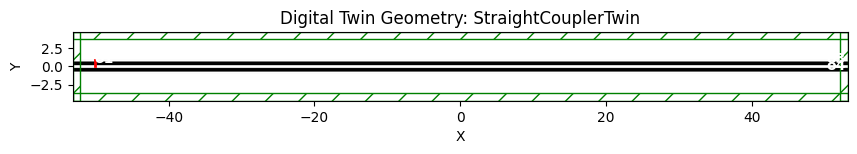

In [7]:
print("Checking geometry...")
straight_coupler = StraightCouplerTwin(gap=target_gap, width=width, length=designed_length)
engine.plot_structure(straight_coupler)

In [8]:
wvl, transmission = engine.simulate_component(straight_coupler)

Running FDTD for StraightCouplerTwin...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00123 s
Working in 2D dimensions.
Computational cell is 106.3 x 9.4 x 0 with resolution 50
     block, center = (0,0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)
     block, center = (0,-0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)
time for set_epsilon = 3.23156 s
-----------
on time step 38 (time=0.38), 0.106216 s/step
on time step 76 (time=0.76), 0.105978 s/step
on time step 114 (time=1.14), 0.10765 s/step
on time step 155 (time=1.55), 0.0997786 s/step
on time step 197 (time=1.97), 0.0959994 s/step
on time step 258 (time=2.58), 0.0660955 s/step
on time step 364 (time=3.64), 0.0378524 s/step
on time step 470 (time=4.7), 0.0377596 s/step
on time step 573 (ti

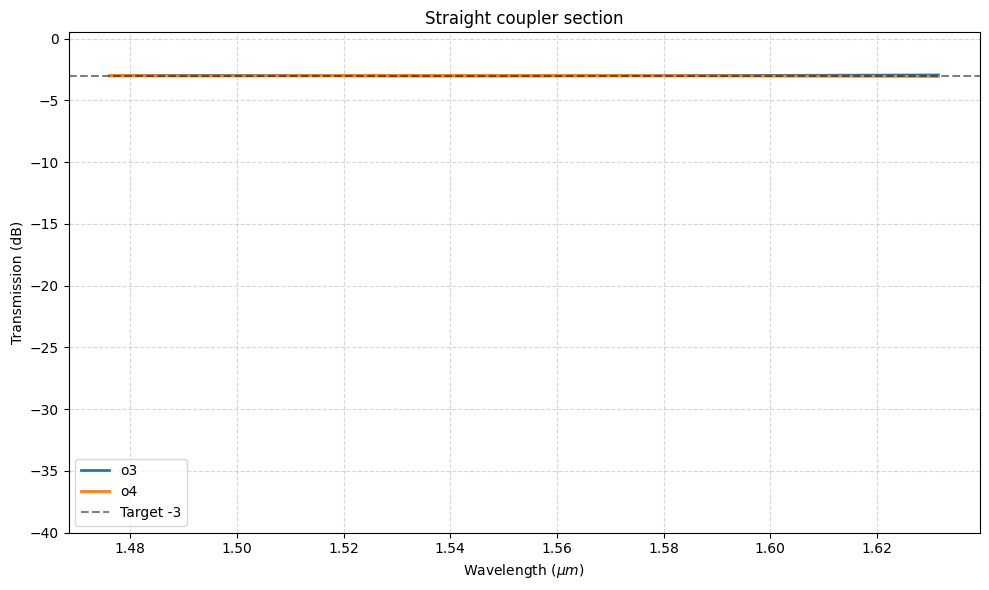

In [9]:
plot_spectra(wvl=wvl, transmissions=transmission, title="Straight coupler section", db_unit=True, target_level=-3)

Plotting Fields...
Running field snapshot (t=50)...
-----------
Initializing structure...
time for choose_chunkdivision = 0.00118113 s
Working in 2D dimensions.
Computational cell is 106.3 x 9.4 x 0 with resolution 50
     block, center = (0,0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)
     block, center = (0,-0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)
time for set_epsilon = 2.92896 s
-----------


FloatProgress(value=0.0, description='0% done ', max=50.0)

Meep progress: 0.38/50.0 = 0.8% done in 4.0s, 528.1s to go
on time step 38 (time=0.38), 0.106324 s/step
Meep progress: 0.93/50.0 = 1.9% done in 8.1s, 424.9s to go
on time step 93 (time=0.93), 0.0728393 s/step
Meep progress: 2.47/50.0 = 4.9% done in 12.1s, 232.2s to go
on time step 247 (time=2.47), 0.0260596 s/step
Meep progress: 3.98/50.0 = 8.0% done in 16.1s, 185.8s to go
on time step 398 (time=3.98), 0.0265173 s/step
Meep progress: 5.5/50.0 = 11.0% done in 20.1s, 162.4s to go
on time step 551 (time=5.51), 0.0263117 s/step
Meep progress: 7.0200000000000005/50.0 = 14.0% done in 24.1s, 147.5s to go
on time step 703 (time=7.03), 0.0264548 s/step
Meep progress: 8.38/50.0 = 16.8% done in 28.1s, 139.5s to go
on time step 839 (time=8.39), 0.0294452 s/step
Meep progress: 9.700000000000001/50.0 = 19.4% done in 32.1s, 133.4s to go
on time step 971 (time=9.71), 0.0303261 s/step
Meep progress: 10.94/50.0 = 21.9% done in 36.1s, 128.9s to go
on time step 1095 (time=10.95), 0.0323917 s/step
Meep pro

run 0 finished at t = 50.0 (5000 timesteps)
     block, center = (0,0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)
     block, center = (0,-0.45,0)
          size (1e+20,0.5,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.0409,12.0409,12.0409)


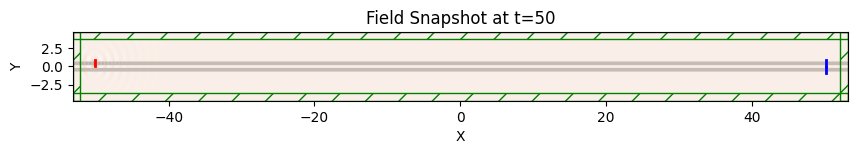

In [10]:
print("Plotting Fields...")
engine.visualize_fields(straight_coupler)

Placeholder

In [11]:
# lengths_to_sweep = np.linspace(designed_length-2, designed_length+2, 6)

# # 2. Run Sweep
# sweep_results = []
# print(f"Starting FDTD Length Sweep for Gap = {target_gap} um...")

# for length in lengths_to_sweep:

#     # There is no need to re-simulate our original length!
#     if length == designed_length:
#         continue

#     # Run simulation at 1.55um center wavelength
#     wl, t_through, t_drop = engine.simulate_coupler(
#         gap=target_gap, 
#         length=length, 
#         width=width, 
#         wavelength=1.55
#     )
    
#     # Extract values specifically at 1.55um
#     idx_wvl = np.argmin(np.abs(wl - wavelength))
#     val_through = t_through[idx_wvl]
#     val_drop = t_drop[idx_wvl]
    
#     sweep_results.append({
#         "length": length,
#         "through": val_through,
#         "drop": val_drop
#     })
#     print(f"L={length:.2f} um | Through={val_through:.2f} dB | Drop={val_drop:.2f} dB")

In [12]:
radius_dy = 5.0  # Vertical offset for S-bend
radius_dx = 10.0 # Horizontal length for S-bend

Measuring Parasitic Coupling in S-Bends...
     prism, center = (-1.85235e-16,-1.03048,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 374 vertices:
          (-10,-2.3,0)
          (-10,-1.8,0)
          (-9.851,-1.799,0)
          (-9.704,-1.798,0)
          (-9.561,-1.794,0)
          (-9.421,-1.79,0)
          (-9.283,-1.785,0)
          (-9.149,-1.778,0)
          (-9.017,-1.771,0)
          (-8.888,-1.762,0)
          (-8.762,-1.752,0)
          (-8.638,-1.741,0)
          (-8.517,-1.73,0)
          (-8.398,-1.717,0)
          (-8.281,-1.703,0)
          (-8.167,-1.689,0)
          (-8.055,-1.673,0)
          (-7.945,-1.657,0)
          (-7.838,-1.64,0)
          (-7.732,-1.622,0)
          (-7.629,-1.603,0)
          (-7.527,-1.583,0)
          (-7.427,-1.563,0)
          (-7.329,-1.542,0)
          (-7.233,-1.521,0)
          (-7.138,-1.498,0)
          (-7.045,-1.475,0)
          (-6.953,-1.452,0)
          (-6.863,-1.428,0)
          (-6.774,-1.403,0)


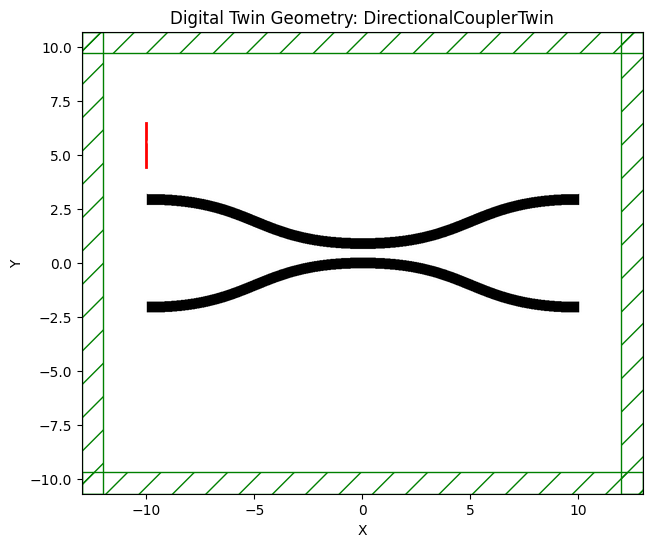

In [13]:
print("Measuring Parasitic Coupling in S-Bends...")
sbend_model = DirectionalCouplerTwin(
    gap=target_gap, 
    width=width, 
    length_straight=0.0, 
    length_bend=radius_dx, 
    dy=radius_dy
)
engine.plot_structure(sbend_model)

In [14]:
wvl, transmission_sbend = engine.simulate_component(sbend_model)

Running FDTD for DirectionalCouplerTwin...
-----------
Initializing structure...
time for choose_chunkdivision = 0.01209 s
Working in 2D dimensions.
Computational cell is 26 x 21.4 x 0 with resolution 50
     prism, center = (-1.85235e-16,-1.03048,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 374 vertices:
          (-10,-2.3,0)
          (-10,-1.8,0)
          (-9.851,-1.799,0)


          (-9.704,-1.798,0)
          (-9.561,-1.794,0)
          (-9.421,-1.79,0)
          (-9.283,-1.785,0)
          (-9.149,-1.778,0)
          (-9.017,-1.771,0)
          (-8.888,-1.762,0)
          (-8.762,-1.752,0)
          (-8.638,-1.741,0)
          (-8.517,-1.73,0)
          (-8.398,-1.717,0)
          (-8.281,-1.703,0)
          (-8.167,-1.689,0)
          (-8.055,-1.673,0)
          (-7.945,-1.657,0)
          (-7.838,-1.64,0)
          (-7.732,-1.622,0)
          (-7.629,-1.603,0)
          (-7.527,-1.583,0)
          (-7.427,-1.563,0)
          (-7.329,-1.542,0)
          (-7.233,-1.521,0)
          (-7.138,-1.498,0)
          (-7.045,-1.475,0)
          (-6.953,-1.452,0)
          (-6.863,-1.428,0)
          (-6.774,-1.403,0)
          (-6.686,-1.378,0)
          (-6.599,-1.352,0)
          (-6.514,-1.326,0)
          (-6.43,-1.299,0)
          (-6.347,-1.272,0)
          (-6.264,-1.244,0)
          (-6.102,-1.188,0)
          (-6.022,-1.159,0)
          (-5.943,-1.13,

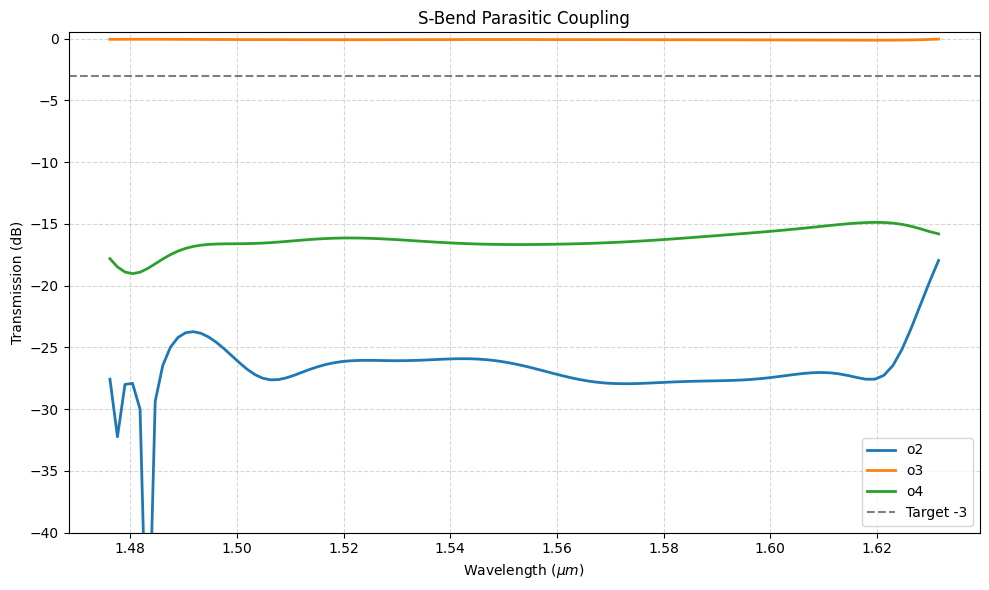

In [15]:
plot_spectra(wvl=wvl, transmissions=transmission_sbend, title="S-Bend Parasitic Coupling", db_unit=True, target_level=-3)

Run final simulation for the DC = bends + straight section

Full final DC model
     prism, center = (50.1475,-1.025,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 376 vertices:
          (-10,-2.3,0)
          (-10,-1.8,0)
          (-9.851,-1.799,0)
          (-9.704,-1.798,0)
          (-9.561,-1.794,0)
          (-9.421,-1.79,0)
          (-9.283,-1.785,0)
          (-9.149,-1.778,0)
          (-9.017,-1.771,0)
          (-8.888,-1.762,0)
          (-8.762,-1.752,0)
          (-8.638,-1.741,0)
          (-8.517,-1.73,0)
          (-8.398,-1.717,0)
          (-8.281,-1.703,0)
          (-8.167,-1.689,0)
          (-8.055,-1.673,0)
          (-7.945,-1.657,0)
          (-7.838,-1.64,0)
          (-7.732,-1.622,0)
          (-7.629,-1.603,0)
          (-7.527,-1.583,0)
          (-7.427,-1.563,0)
          (-7.329,-1.542,0)
          (-7.233,-1.521,0)
          (-7.138,-1.498,0)
          (-7.045,-1.475,0)
          (-6.953,-1.452,0)
          (-6.863,-1.428,0)
          (-6.774,-1.403,0)
          (-6.686,-1.378,0)
  

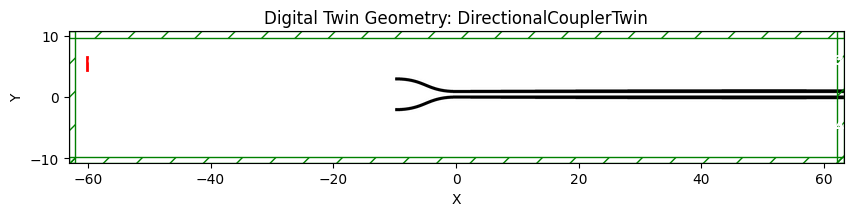

In [16]:
coupling_length = designed_length

print("Full final DC model")
full_dc_model = DirectionalCouplerTwin(
    gap=target_gap, 
    width=width, 
    length_straight=designed_length, 
    length_bend=radius_dx, 
    dy=radius_dy
)
engine.plot_structure(full_dc_model)

In [17]:
wvl, full_transmission = engine.simulate_component(full_dc_model)

Running FDTD for DirectionalCouplerTwin...
-----------
Initializing structure...
time for choose_chunkdivision = 0.0176671 s
Working in 2D dimensions.
Computational cell is 126.3 x 21.4 x 0 with resolution 50
     prism, center = (50.1475,-1.025,5e+19)
          height 1e+20, axis (0,0,1), sidewall angle: 0 radians, 376 vertices:
          (-10,-2.3,0)
          (-10,-1.8,0)
          (-9.851,-1.799,0)
          (-9.704,-1.798,0)


          (-9.561,-1.794,0)
          (-9.421,-1.79,0)
          (-9.283,-1.785,0)
          (-9.149,-1.778,0)
          (-9.017,-1.771,0)
          (-8.888,-1.762,0)
          (-8.762,-1.752,0)
          (-8.638,-1.741,0)
          (-8.517,-1.73,0)
          (-8.398,-1.717,0)
          (-8.281,-1.703,0)
          (-8.167,-1.689,0)
          (-8.055,-1.673,0)
          (-7.945,-1.657,0)
          (-7.838,-1.64,0)
          (-7.732,-1.622,0)
          (-7.629,-1.603,0)
          (-7.527,-1.583,0)
          (-7.427,-1.563,0)
          (-7.329,-1.542,0)
          (-7.233,-1.521,0)
          (-7.138,-1.498,0)
          (-7.045,-1.475,0)
          (-6.953,-1.452,0)
          (-6.863,-1.428,0)
          (-6.774,-1.403,0)
          (-6.686,-1.378,0)
          (-6.599,-1.352,0)
          (-6.514,-1.326,0)
          (-6.43,-1.299,0)
          (-6.347,-1.272,0)
          (-6.264,-1.244,0)
          (-6.102,-1.188,0)
          (-6.022,-1.159,0)
          (-5.943,-1.13,0)
          (-5.864,-1.1,0)

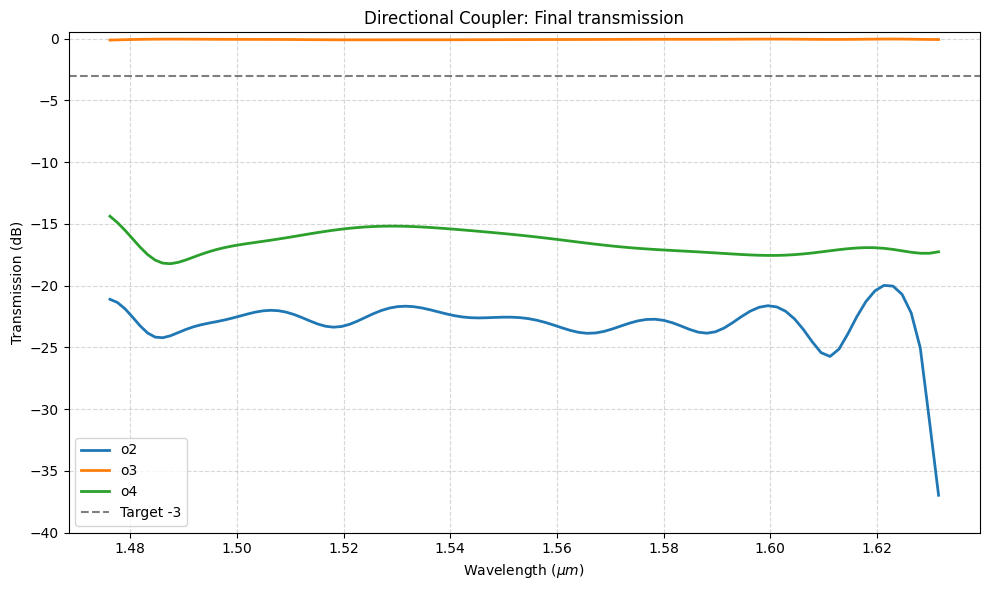

In [18]:
plot_spectra(wvl=wvl, transmissions=full_transmission, title="Directional Coupler: Final transmission", db_unit=True, target_level=-3)

Save compact model (S-parameters)

In [24]:
designed_length

100.29491584321266

#### Layout (GDSFactory)

In [19]:
dc = gf.components.coupler(
    gap = target_gap,
    length = designed_length,
    dx = 10.0,
    dy = 5.0
)

Layout generated: directional_coupler.gds (L=100.29491584321266 um, Gap=0.4 um)


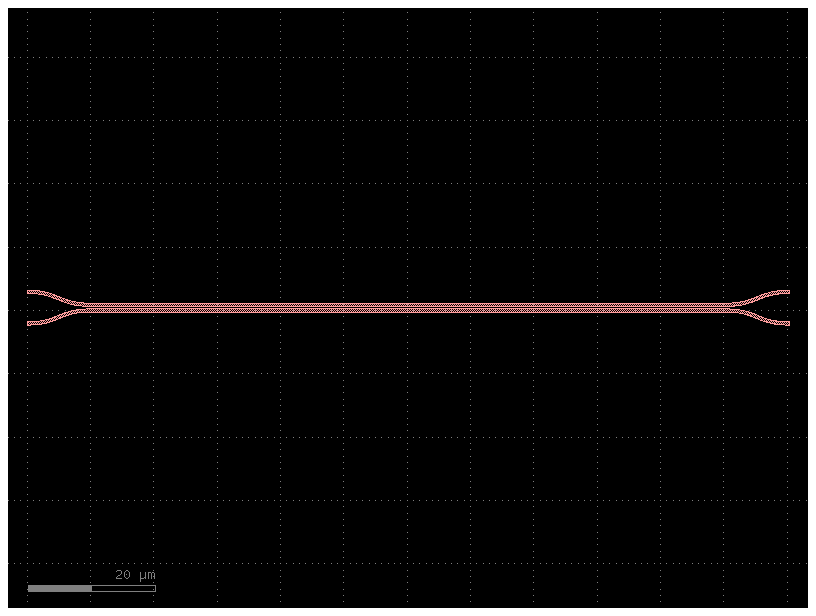

In [20]:
dc.plot()

gds_name = "directional_coupler.gds"
dc.write_gds(f".gds/{gds_name}")
print(f"Layout generated: {gds_name} (L={designed_length} um, Gap={target_gap} um)")